In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/pneumonia dataset FL/train/'
test_dir = '/content/drive/MyDrive/pneumonia dataset FL/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

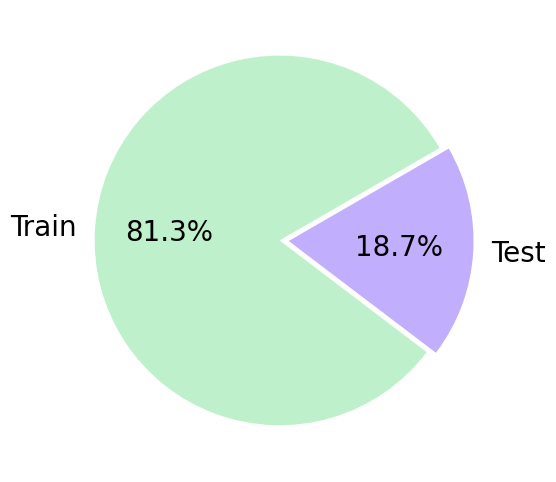

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

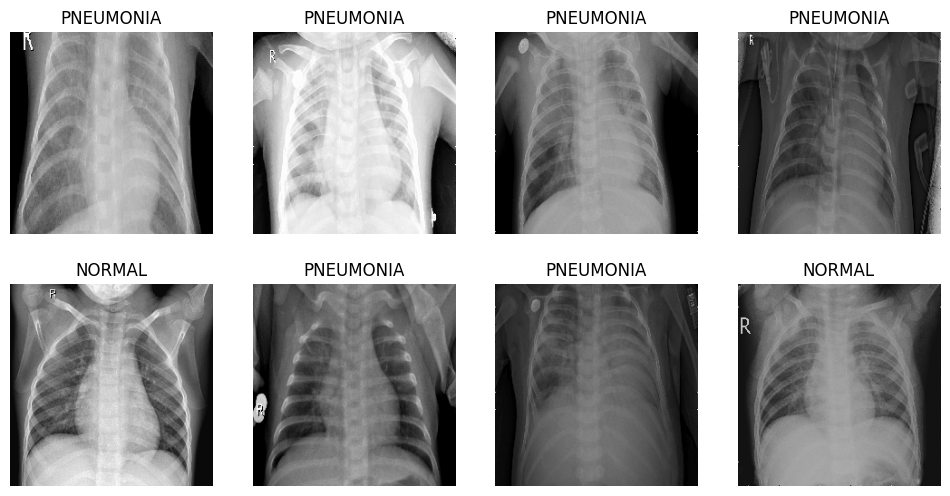

In [6]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [7]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [8]:
base_model = NASNetMobile(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

19993432/19993432 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 flatten (Flatten)           (None, 51744)             0         
                                                                 
 dropout (Dropout)           (None, 51744)             0         
                                                                 
 dense (Dense)               (None, 128)               6623360   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 10893334 (41.55 MB)
Trainable params: 6623

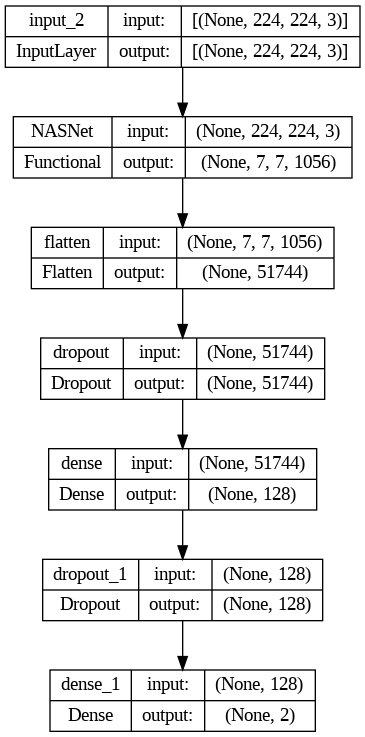

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 730s 3s/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9085
Epoch 2/10
234/234 [==============================] - 70s 297ms/step - loss: 0.1206 - sparse_categorical_accuracy: 0.9507
Epoch 3/10
234/234 [==============================] - 68s 292ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9608
Epoch 4/10
234/234 [==============================] - 69s 296ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9728
Epoch 5/10
234/234 [==============================] - 69s 293ms/step - loss: 0.0656 - sparse_categorical_accuracy: 0.9734
Epoch 6/10
234/234 [==============================] - 70s 298ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9758
Epoch 7/10
234/234 [==============================] - 68s 292ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9773
Epoch 8/10
234/234 [==============================] - 68s 292ms/step - loss: 0.0531 - sparse_categorical_accuracy: 0.9798
Epoch 9/10
234/234 [======

# Federated Learning Based transfer Learning enabled NASNetMobile Model

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 30s 288ms/step - loss: 0.0389 - sparse_categorical_accuracy: 0.9836
Epoch 2/5
58/58 [==============================] - 17s 275ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9878
Epoch 3/5
58/58 [==============================] - 18s 307ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9957
Epoch 4/5
58/58 [==============================] - 16s 283ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9922
Epoch 5/5
58/58 [==============================] - 16s 282ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9922
Epoch 1/5
58/58 [==============================] - 31s 298ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9879
Epoch 2/5
58/58 [==============================] - 17s 289ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9809
Epoch 3/5
58/58 [==============================] - 16s 285ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9870
Epoch 4/5
58/58 [==============================]

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  3%|▎         | 1/36 [00:19<11:24, 19.56s/it]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 2/36 [00:35<09:43, 17.16s/it]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 3/36 [00:49<08:45, 15.92s/it]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 4/36 [01:03<08:09, 15.28s/it]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 5/36 [01:18<07:47, 15.08s/it]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 6/36 [01:32<07:25, 14.87s/it]

1/1 [==============================] - 0s 92ms/step


 19%|█▉        | 7/36 [01:48<07:13, 14.94s/it]

1/1 [==============================] - 0s 63ms/step


 22%|██▏       | 8/36 [02:02<06:52, 14.73s/it]

1/1 [==============================] - 0s 64ms/step


 25%|██▌       | 9/36 [02:16<06:34, 14.62s/it]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 10/36 [02:30<06:13, 14.38s/it]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 11/36 [02:44<05:57, 14.30s/it]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 12/36 [02:58<05:37, 14.07s/it]

1/1 [==============================] - 0s 79ms/step


 36%|███▌      | 13/36 [03:12<05:22, 14.00s/it]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 14/36 [03:25<05:06, 13.94s/it]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 15/36 [03:40<04:58, 14.23s/it]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 16/36 [03:55<04:49, 14.46s/it]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 17/36 [04:10<04:36, 14.58s/it]

1/1 [==============================] - 0s 81ms/step


 50%|█████     | 18/36 [04:24<04:20, 14.48s/it]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 19/36 [04:39<04:09, 14.65s/it]

1/1 [==============================] - 0s 73ms/step


 56%|█████▌    | 20/36 [04:53<03:50, 14.39s/it]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 21/36 [05:08<03:36, 14.43s/it]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 22/36 [05:22<03:21, 14.41s/it]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 23/36 [05:37<03:08, 14.51s/it]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 24/36 [05:52<02:54, 14.57s/it]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 25/36 [06:07<02:42, 14.77s/it]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 26/36 [06:22<02:29, 14.99s/it]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 27/36 [06:38<02:16, 15.16s/it]

1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 28/36 [06:52<01:59, 14.89s/it]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 29/36 [07:06<01:42, 14.57s/it]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 30/36 [07:21<01:29, 14.85s/it]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 31/36 [07:36<01:13, 14.76s/it]

1/1 [==============================] - 0s 66ms/step


 89%|████████▉ | 32/36 [07:50<00:58, 14.64s/it]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 33/36 [08:06<00:44, 14.93s/it]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 34/36 [08:22<00:30, 15.24s/it]

1/1 [==============================] - 0s 81ms/step


 97%|█████████▋| 35/36 [08:37<00:15, 15.26s/it]

1/1 [==============================] - 0s 55ms/step


100%|██████████| 36/36 [08:53<00:00, 15.34s/it]

1/1 [==============================] - 5s 5s/step


37it [09:07, 14.80s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.92      0.94      0.93       317
   PNEUMONIA       0.98      0.97      0.97       855

    accuracy                           0.96      1172
   macro avg       0.95      0.96      0.95      1172
weighted avg       0.96      0.96      0.96      1172



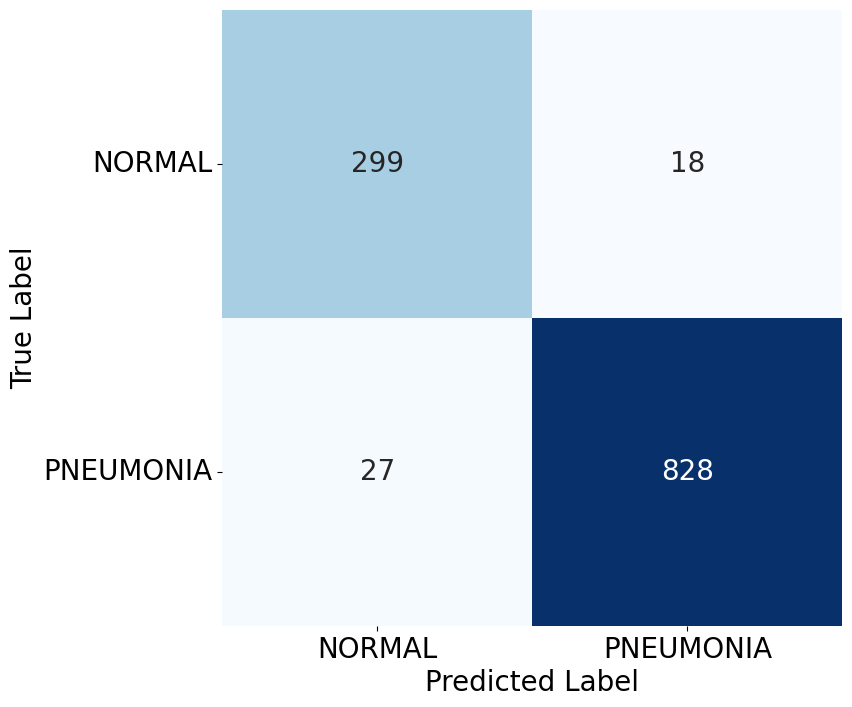

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



# Improved Code of Transfer Learning Based NASNetMobile Model

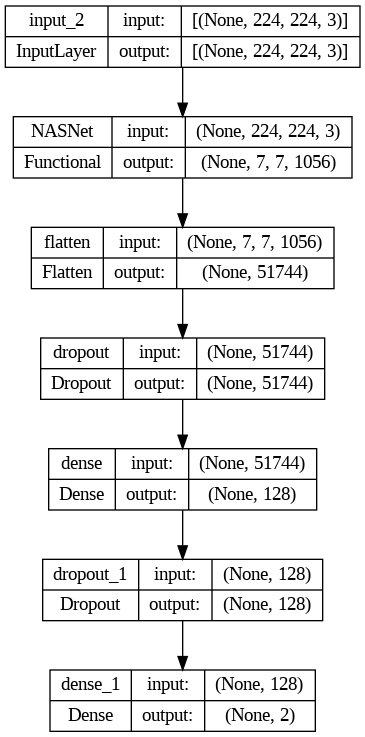

In [16]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [18]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 83s 298ms/step - loss: 0.0297 - sparse_categorical_accuracy: 0.9880
Epoch 2/10
234/234 [==============================] - 69s 296ms/step - loss: 0.0271 - sparse_categorical_accuracy: 0.9904
Epoch 3/10
234/234 [==============================] - 69s 295ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9893
Epoch 4/10
234/234 [==============================] - 68s 292ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9925
Epoch 5/10
234/234 [==============================] - 69s 296ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9934
Epoch 6/10
234/234 [==============================] - 69s 293ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9940
Epoch 7/10
234/234 [==============================] - 68s 293ms/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9955
Epoch 8/10
234/234 [==============================] - 68s 292ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9919
Epoch 9/10
234/234 [====

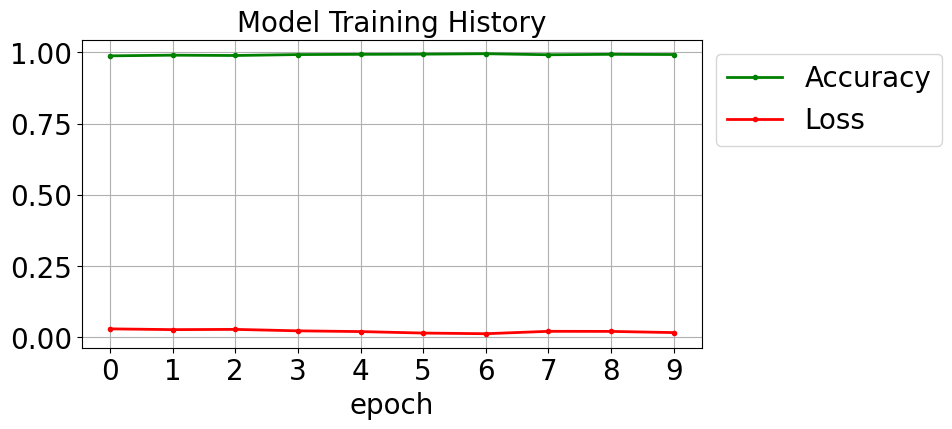

In [19]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [20]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  3%|▎         | 1/36 [00:04<02:53,  4.95s/it]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 2/36 [00:05<01:21,  2.40s/it]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 3/36 [00:06<00:52,  1.59s/it]

1/1 [==============================] - 0s 58ms/step


 11%|█         | 4/36 [00:06<00:38,  1.20s/it]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 5/36 [00:07<00:30,  1.01it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 6/36 [00:08<00:26,  1.15it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 7/36 [00:08<00:23,  1.25it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 8/36 [00:09<00:21,  1.32it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▌       | 9/36 [00:09<00:18,  1.43it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 10/36 [00:10<00:16,  1.53it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 11/36 [00:11<00:15,  1.58it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 12/36 [00:11<00:15,  1.58it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▌      | 13/36 [00:12<00:15,  1.49it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 14/36 [00:13<00:15,  1.40it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 15/36 [00:14<00:16,  1.25it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 16/36 [00:15<00:15,  1.26it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 17/36 [00:15<00:14,  1.30it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 18/36 [00:16<00:12,  1.42it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 19/36 [00:16<00:11,  1.47it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 20/36 [00:17<00:10,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 21/36 [00:18<00:09,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 22/36 [00:18<00:08,  1.58it/s]

1/1 [==============================] - 0s 65ms/step


 64%|██████▍   | 23/36 [00:19<00:08,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 24/36 [00:19<00:07,  1.63it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 25/36 [00:20<00:06,  1.57it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 26/36 [00:21<00:06,  1.56it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 27/36 [00:21<00:05,  1.58it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 28/36 [00:22<00:04,  1.64it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 29/36 [00:23<00:04,  1.64it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 30/36 [00:23<00:03,  1.66it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 31/36 [00:24<00:02,  1.67it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 32/36 [00:24<00:02,  1.64it/s]

1/1 [==============================] - 0s 74ms/step


 92%|█████████▏| 33/36 [00:25<00:01,  1.61it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 34/36 [00:26<00:01,  1.45it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 35/36 [00:27<00:00,  1.40it/s]

1/1 [==============================] - 0s 81ms/step


100%|██████████| 36/36 [00:28<00:00,  1.27it/s]

1/1 [==============================] - 4s 4s/step


37it [00:32,  1.14it/s]


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.93      0.94      0.94       317
   PNEUMONIA       0.98      0.97      0.98       855

    accuracy                           0.97      1172
   macro avg       0.95      0.96      0.96      1172
weighted avg       0.97      0.97      0.97      1172



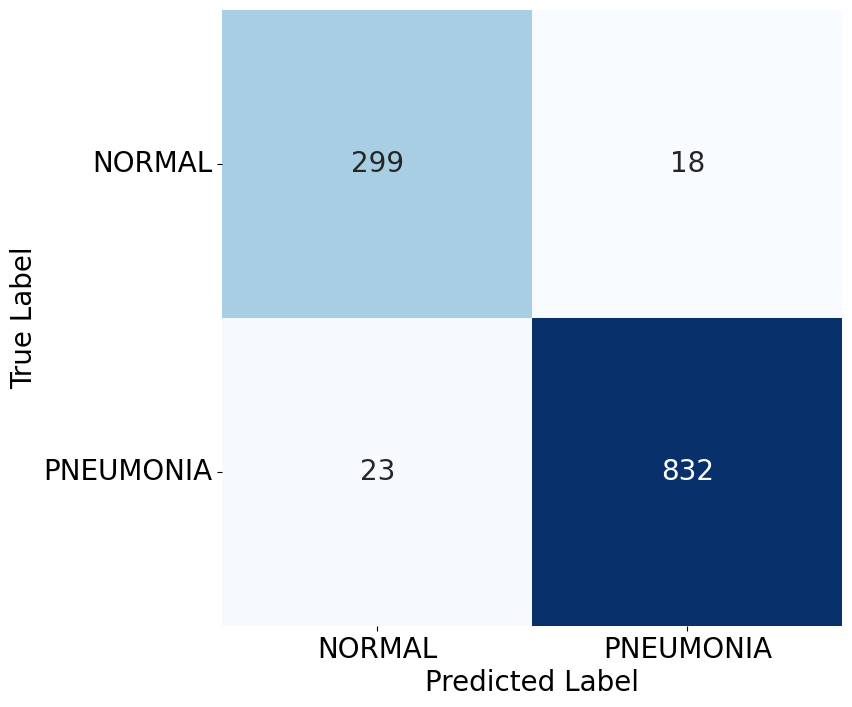

In [22]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [23]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 832.000000 TN: 299.000000 FP: 18.000000 FN: 23.000000


In [25]:
tn, fp, fn, tp = cm.ravel()
acc = (tp+tn)/(tp+tn+fp+fn)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))

Accuracy: 96.50%
Precision: 97.88%
Recall or Sensitivity: 97.31%
Specificity: 94.32%
F1-score: 97.60%
